# Task 4: Routing


## Reproduction of the task 1 ETL pipeline

The first cells only make sure that the file root is set correct and the database connection is build.

In [1]:
import sys
from pathlib import Path

repo_root = Path("..").resolve()
if repo_root.as_posix() not in sys.path:
    sys.path.insert(0, repo_root.as_posix())

In [2]:
from src.timetable_etl.config import Settings
from src.timetable_etl.db import connect

settings = Settings.from_env()
print(settings)
conn = connect(settings)

Settings(db_host='localhost', db_name='postgres', db_user='postgres', db_password='1234', station_json_path=PosixPath('/Users/rebeccamerdes/Desktop/TU/master/DIA/repo/DIA/DBahn-berlin/repo/station_data.json'), planned_archives_path=PosixPath('/Users/rebeccamerdes/Desktop/TU/master/DIA/repo/DIA/DBahn-berlin/repo/timetables'), changes_archives_path=PosixPath('/Users/rebeccamerdes/Desktop/TU/master/DIA/repo/DIA/DBahn-berlin/repo/timetable_changes'), archive_pattern='*.tar.gz', timezone='Europe/Berlin', match_threshold=0.75, ambiguity_delta=0.02, planned_batch_size=5000, change_batch_size=50000)


## Step 0: Deduplication Investigation

We just wanted to show the we have investigated the duplicate keys exist in the ``stop_id`` attribute and thus, deduplication is necessary.

In [3]:
from src.timetable_etl.dedup_invest import count_stop_id_duplicates
import os
count_stop_id_duplicates(os.path.join(repo_root, "timetables"))

{'files_processed': 135692,
 'stop_id_total': 2104080,
 'stop_id_unique': 2085472,
 'stop_id_duplicates': 18608,
 'duplicate_ids': 18608}

In [4]:
count_stop_id_duplicates(os.path.join(repo_root, "timetable_changes"))

{'files_processed': 540668,
 'stop_id_total': 1686852,
 'stop_id_unique': 1118918,
 'stop_id_duplicates': 567934,
 'duplicate_ids': 360890}

#### Step 1: Build Station Table

The imported function reads the ``stations_data.json`` and builds the station dimension table from it.

In [5]:
from src.timetable_etl.stations import import_stationen

n = import_stationen(conn, settings.station_json_path)
print("Upserted station rows:", n)

Upserted station rows: 133


---

## Task 4-specific adaptions

#### Step 2: Build other Dimension Tables + Fact Table

The imported function builds the other dimension tables. Also, it iterates the ``timetables`` directory and inserts the planned values into the stops table.

In [6]:
from src.timetable_etl.stops_planned import import_stops_from_archives

planned_res = import_stops_from_archives(
    conn,
    settings.planned_archives_path,
    pattern=settings.archive_pattern,
    timezone=settings.timezone,
    match_threshold=settings.match_threshold,
    ambiguity_delta=settings.ambiguity_delta,
    batch_size=settings.planned_batch_size,
)
planned_res

{'archives_processed': 135692,
 'stops_upserted': 2094358,
 'unmatched_stations': []}

In [7]:
# test
conn.rollback() 

query = """
SELECT table_schema, table_name
FROM information_schema.tables
WHERE table_name = 'stops';
"""

with conn.cursor() as cur:
    cur.execute(query)
    rows = cur.fetchall()

rows


[('public', 'stops')]

In [8]:
conn.rollback()

with conn.cursor() as cur:
    cur.execute("""
        SELECT column_name
        FROM information_schema.columns
        WHERE table_schema = 'public'
          AND table_name = 'stops'
        ORDER BY ordinal_position;
    """)
    cols = [r[0] for r in cur.fetchall()]

cols


['stop_id',
 'eva',
 'train_id',
 'arrival_pt_id',
 'departure_pt_id',
 'arrival_ct_id',
 'departure_ct_id',
 'arrival_clt_id',
 'departure_clt_id',
 'arrival_cs',
 'departure_cs',
 'arrival_pp',
 'departure_pp',
 'arrival_cp',
 'departure_cp',
 'stop_sequence_index']

#### skip -> Step 3: Insert Change Values to Fact Table

The imported function iterates the ``timetable_changes`` directory and updates the stops table accordingly.

In [10]:
from src.timetable_etl.stops_changed import process_change_archives

changed_res = process_change_archives(
    conn,
    settings.changes_archives_path,
    pattern=settings.archive_pattern,
    batch_size=settings.change_batch_size,
)
changed_res


{'archives_processed': 540668, 'stops_updated': 1132029}

### New step: add stop order index

In [9]:
from src.timetable_etl.stop_sequence import ensure_stop_sequence_column

conn.rollback()

ensure_stop_sequence_column(conn)

In [10]:
conn.rollback()
from src.timetable_etl.stop_sequence import compute_stop_sequence

compute_stop_sequence(conn)


### 4.1: Shortest route (graph building)

In [11]:
# nodes = stations (identified by eva)
# create edges from stop_sequence_index = i -> i+1

from src.timetable_etl.station_graph import build_station_graph

g_station, eva_to_vertex = build_station_graph(conn)

In [12]:
# get all station evas for easy start / goal reference
with conn.cursor() as cur:
    cur.execute("SELECT eva, name FROM stationen")
    eva_to_name = dict(cur.fetchall())

for eva, name in sorted(eva_to_name.items(), key=lambda x: x[1]):
    print(f"{eva}: {name}")

8011003: Ahrensfelde
8080040: Albrechtshof
8011155: Alexanderplatz
8089103: Alt-Reinickendorf
8089054: Altglienicke
8089003: Attilastraße
8089004: Baumschulenweg
8089005: Bellevue
8089002: Berlin Anhalter Bahnhof
8089044: Berlin Brandenburger Tor
8089013: Berlin Frankfurter Allee
8011102: Berlin Gesundbrunnen
8011160: Berlin Hauptbahnhof
8010255: Berlin Ostbahnhof
8011162: Berlin Ostkreuz
8011118: Berlin Potsdamer Platz
8011113: Berlin Südkreuz
8089051: Berlin Yorckstr.(S1)
8089050: Berlin Yorckstr.(S2)
8010406: Berlin Zoologischer Garten
8089052: Berlin-Adlershof
8089056: Berlin-Blankenburg
8089057: Berlin-Buch
8010403: Berlin-Charlottenburg
8089060: Berlin-Friedrichshagen
8011306: Berlin-Friedrichstraße
8089061: Berlin-Frohnau
8089062: Berlin-Grunewald
8089063: Berlin-Grünau
8089109: Berlin-Halensee
8089064: Berlin-Hermsdorf
8011901: Berlin-Hohenschönhausen
8010035: Berlin-Karlshorst
8011046: Berlin-Karow
8089068: Berlin-Kaulsdorf
8089069: Berlin-Köpenick
8010036: Berlin-Lichtenberg


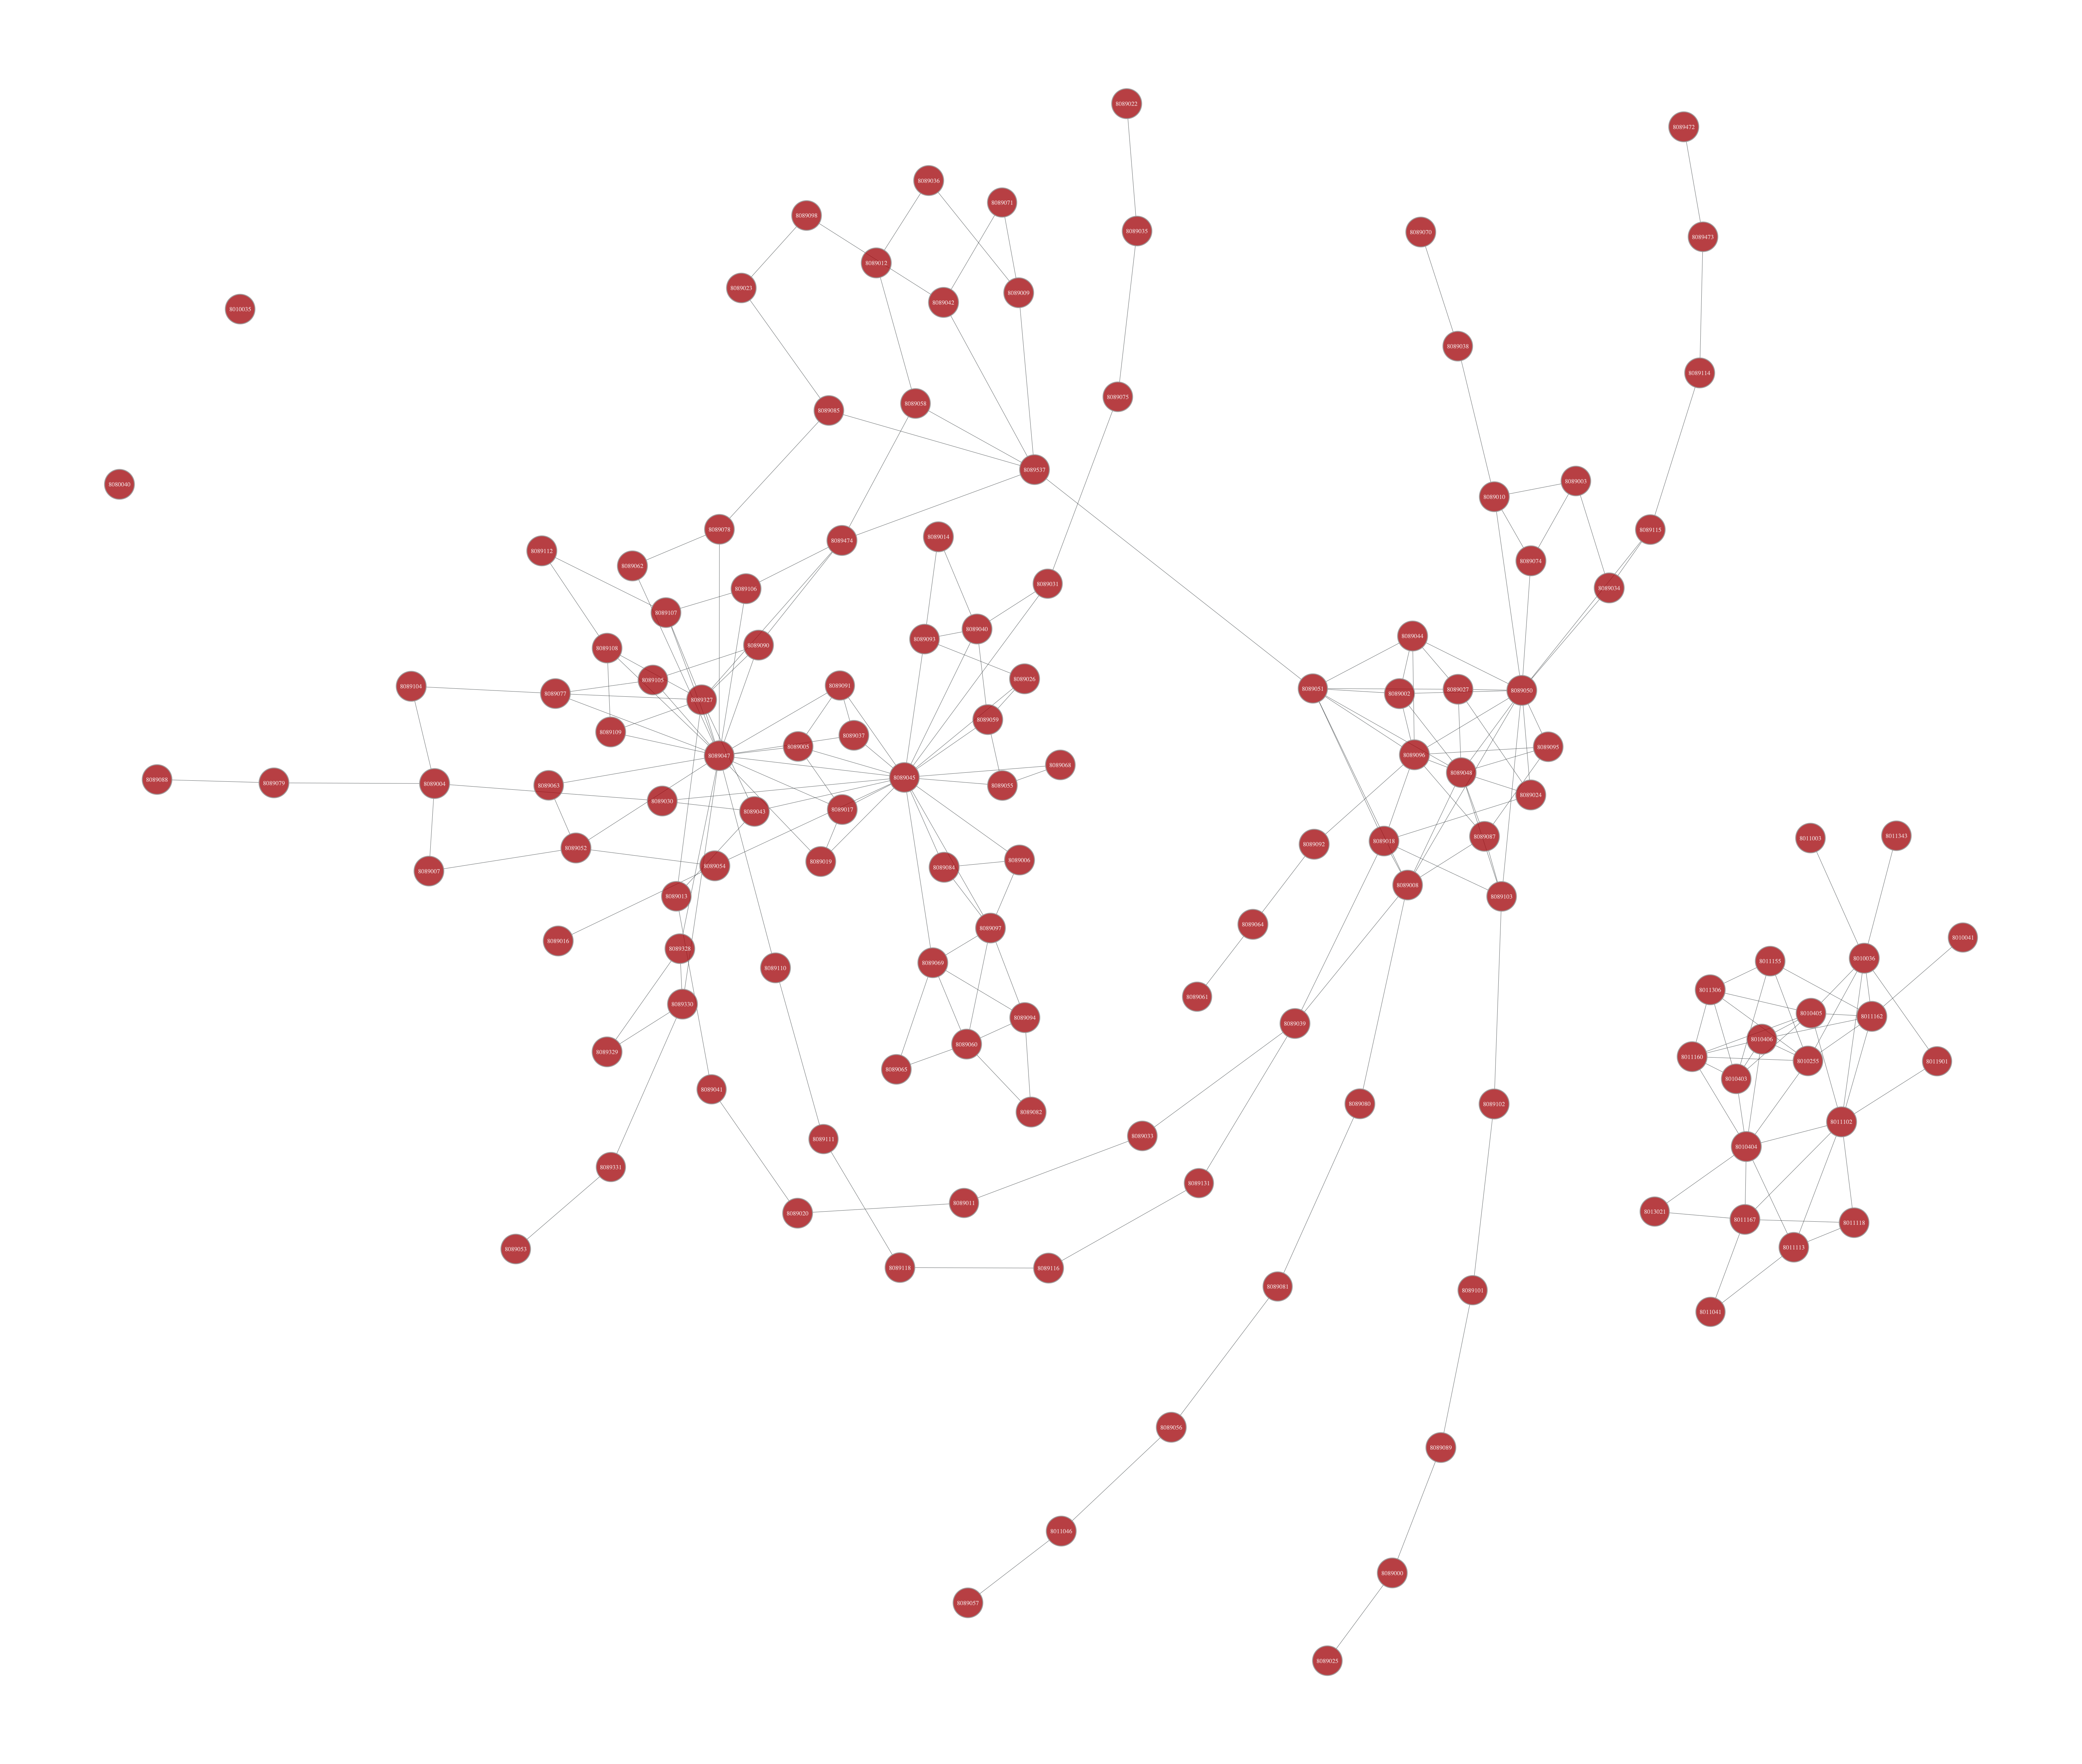

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x125f3db50, at 0x1347f5bd0>

In [13]:
import graph_tool.all as gt

gt.graph_draw(
    g_station,
    output_size=(3000, 3000),
    vertex_size=15,
    edge_pen_width=0.5, 
    vertex_text=g_station.vertex_properties["eva"]
)


#gt.graph_draw(g_station, vertex_text=g_station.vertex_properties["name"])


### checks

In [14]:
# degree distribution
degrees = g_station.get_total_degrees(g_station.get_vertices())
print("max degree:", degrees.max())
print("mean degree:", degrees.mean())
print("isolated nodes:", (degrees == 0).sum())


max degree: 21
mean degree: 3.6390977443609023
isolated nodes: 2


### Path finding (graph hops)

In [28]:
from graph_tool.topology import all_shortest_paths

# todo: change request style?

#from_s = eva_to_vertex[8089091] # tiergarten
#from_s = eva_to_vertex[8089131] # wedding
from_s = eva_to_vertex[8089039] # schönhauser alle
# from_s = eva_to_vertex[8089033] # prenzlauer alle
# from_s = eva_to_vertex[8011162] # ostkreuz

#to_s   = eva_to_vertex[8011160] # hbf
#to_s   = eva_to_vertex[8089118] # beusselstr
# to_s = eva_to_vertex[8089013] # frankfurter str
#to_s = eva_to_vertex[8089041] # storkower str
to_s = eva_to_vertex[8011162] # ostkreuz


paths = list(all_shortest_paths(g_station, from_s, to_s))

eva_prop = g_station.vertex_properties["eva"]

all_paths = [
    [eva_prop[v] for v in path]
    for path in paths
]

# for p in all_paths: # eva numbers
#    print(p)

# look at paths
name = g_station.vertex_properties["name"]

if len(paths) == 0:
    print("No paths found between ", name[from_s], ", and ", name[to_s],"!")
else:
    for path in paths:
        print(" -> ".join(name[v] for v in path))

No paths found between  Schönhauser Allee , and  Berlin Ostkreuz !


In [20]:
from src.timetable_etl.graph_helpers import print_station_edges

#print_station_edges(g_station, 8089091, eva_to_vertex) # tiergarten
#print_station_edges(g_station, 8089011, eva_to_vertex) # greifswalder str
print_station_edges(g_station, 8011160, eva_to_vertex) # bhf
print_station_edges(g_station, 8011162, eva_to_vertex) # ostkreuz



Connections of Berlin Hauptbahnhof (8011160):
  -> Berlin-Friedrichstraße
  -> Berlin-Charlottenburg
  -> Berlin-Spandau
  -> Berlin-Wannsee
  -> Berlin Zoologischer Garten
  -> Berlin Ostbahnhof
Connections of Berlin Ostkreuz (8011162):
  -> Berlin-Lichtenberg
  -> Berlin-Schöneweide Pbf
  -> Berlin Ostbahnhof
  -> Berlin-Wannsee
  -> Berlin Zoologischer Garten
  -> Berlin Gesundbrunnen
  -> Alexanderplatz


### 4.2: Earliest arrival

In [ ]:
# nodes = stations (eva) and trips
# edges = departure edge and arrival edge

In [ ]:
conn.close()